# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções Auxiliares](#Funções-Auxiliares)

[Funções de Custo](#Funções-de-Custo)

[Inicialização de Pesos](#Inicialização-de-Pesos)

[Implementação](#Implementação)

[Testes da Implementação](#Testes-da-Implementação)

- [Exemplos do Notebook da Intuição](#Exemplos-do-Notebook-da-Intuição)

- [Regressão](#Regressão)
    - [Regressão Linear Simples](#Regressão-Linear-Simples---Exemplo-do-Perceptron)
    - [Regressão Linear Multivariada](#Regressão-Linear-Multivariada---Exerc%C3%ADcio-de-Regressão-do-Perceptron)
    - [Regressão Quadrática](#Regressão-Quadrática)
    - [Regressão Cúbica](#Regressão-Cúbica)
    - [Regressão Logarítimica](#Regressão-Logar%C3%ADtimica)
    - [Regressão Exponencial](#Regressão-Exponencial)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Moons](#Moons)
    - [Espiral](#Espiral)
    
- [Classificação Multiclasse](#Classificação-Multiclasse)
    - [3 Clusters Multiclasse](#3-Clusters-Multiclasse)
    - [4 Clusters Multiclasse](#4-Clusters-Multiclasse)
    - [Espiral - 5 Classes](#Espiral---5-Classes)
    - [Make Classification - 4 Classes](#Make-Classification---4-Classes)
    - [Iris Dataset](#Iris-Dataset)

[Referências](#Referências)

# Imports and Configurações

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons, make_classification
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plots
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10

%matplotlib inline

# Funções de Ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0.1, 1)
    return np.where(x < 0, 0.1*x, x)

def gaussian(x, derivative=False):
    if derivative:
        return -2*x*np.exp(-x**2)
    return np.exp(-x**2)

# Funções Auxiliares

In [3]:
def softmax(x, y_oh=None, derivative=False):
    if derivative: 
        y_pred = softmax(x)
        y_correct = np.argmax(y_oh, axis=1)
        pk = y_pred[range(y_pred.shape[0]), y_correct]
        y_pred[range(y_pred.shape[0]), y_correct] = pk*(1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

def neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_pred[range(y_pred.shape[0]), y_correct]
    if derivative:
        y_pred[range(y_pred.shape[0]), y_correct] = (-1.0/pk)
        return y_pred
    return np.mean(-np.log(pk))

# Funções de Custo

###### Para Regressão

In [4]:
def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return np.mean((y - y_pred)**2)

###### Para Classificação Binária

In [5]:
def sigmoid_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

###### Para Classificação Multiclasse

In [6]:
def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_softmax[range(y_softmax.shape[0]), y_correct]
    if derivative:
        return -(y_oh - y_softmax)/y_oh.shape[0]
    return np.mean(-np.log(pk))

# Inicialização de Pesos

In [7]:
def ones(rows, cols):
    return np.ones((rows, cols))

def random_normal(rows, cols):
    return np.random.randn(rows, cols)

def random_uniform(rows, cols):
    return np.random.rand(rows, cols)

def glorot_normal(rows, cols):
    # normal com media=0 e stddev=sqrt(3.0 / (out + inp)). Ver notas de np.random.randn.
    std_dev = np.sqrt(3.0 / (rows + cols))
    return std_dev*np.random.randn(rows, cols)

def glorot_uniform(rows, cols):
    # uniforme de [-limit, limit], onde limit = np.sqrt(6.0 / (out + inp))
    limit = np.sqrt(6.0 / (rows + cols))
    return 2*limit*np.random.rand(rows, cols) - limit

# Implementação 

In [8]:
class Layer():
    def __init__(self, input_dim, output_dim, activation=linear, weights_initializer=random_normal, biases_initializer=ones):
        self.input = None
        self.weights = weights_initializer(output_dim, input_dim)
        self.biases = biases_initializer(1, output_dim)
        self.activation = activation
        self._activ_inp, self._activ_out = None, None
        self.dweights, self.dbiases = None, None        

class NeuralNetwork():
    def __init__(self, cost_func, learning_rate=1e-3):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = learning_rate
        
    def fit(self, x, y, epochs=100, verbose=10):
        for epoch in range(epochs+1):
            y_pred = self.__feedforward(x)
            self.__backprop(y, y_pred)
            
            if epoch % verbose == 0:
                cost = self.cost_func(y, y_pred)
                print("epoch: {0:=4}/{1} cost: {2:.8f}".format(epoch, epochs, cost))
        
    def predict(self, x):
        return self.__feedforward(x)
    
    def __feedforward(self, x):
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:]+[Layer(0,0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            current_layer._activ_inp = y
            current_layer._activ_out = next_layer.input = current_layer.activation(y)
        return self.layers[-1]._activ_out
    
    def __backprop(self, y, y_pred):
        last_delta = self.cost_func(y, y_pred, derivative=True)
        for layer in reversed(self.layers):
            dactivation = layer.activation(layer._activ_inp, derivative=True)*last_delta
            last_delta = np.dot(dactivation, layer.weights)
            layer.dweights = np.dot(dactivation.T, layer.input)
            layer.dbiases = 1.0*dactivation.sum(axis=0, keepdims=True)
        
        for layer in reversed(self.layers):
            layer.weights = layer.weights - self.learning_rate*layer.dweights
            layer.biases = layer.biases - self.learning_rate*layer.dbiases

# Testes da Implementação

## Exemplos do Notebook da Intuição

### Exemplo 1

In [8]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

D_in, D_out = x.shape[1], y.shape[1]
nn = NeuralNetwork(cost_func=mse, learning_rate=0.5)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=sigmoid))

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]])
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]])

nn.layers[0].weights = w1
nn.layers[0].biases = b1
nn.layers[1].weights = w2
nn.layers[1].biases = b2

nn.fit(x, y, epochs=0, verbose=1)

for layer in nn.layers:
    print(layer.weights)

epoch:    0/0 cost: 0.29837111
[[ 0.14978072  0.19956143]
 [ 0.24975114  0.29950229]]
[[ 0.35891648  0.40866619]
 [ 0.51130127  0.56137012]]


### Exemplo 2

In [9]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=0.01)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=3, activation=sigmoid))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

for i, w, b in zip(range(3), [w1, w2, w3], [b1, b2, b3]):
    nn.layers[i].weights = w
    nn.layers[i].biases = b

nn.fit(x, y, epochs=300, verbose=30)

for layer in nn.layers:
    print(layer.weights)

epoch:    0/300 cost: 1.16744561
epoch:   30/300 cost: 0.60797958
epoch:   60/300 cost: 0.36558760
epoch:   90/300 cost: 0.24943452
epoch:  120/300 cost: 0.18547915
epoch:  150/300 cost: 0.14614615
epoch:  180/300 cost: 0.11990516
epoch:  210/300 cost: 0.10131084
epoch:  240/300 cost: 0.08751844
epoch:  270/300 cost: 0.07691721
epoch:  300/300 cost: 0.06853445
[[ 0.10083595  0.2016719   0.30585165]
 [ 0.30086971  0.20173942  0.70608796]
 [ 0.40145052  0.30290104  0.91015363]]
[[ 0.20544723  0.30673159  0.50749567]
 [ 0.30994562  0.5123005   0.71366784]
 [ 0.61065514  0.41317913  0.81464085]]
[[ 0.66465527  0.98758148  1.39393956]
 [ 0.05020341  0.44006253 -0.06274803]
 [ 0.18514132 -0.12764401  0.56880846]]


## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

In [13]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)

(100, 2)
(100, 1) (100, 1)


In [14]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())

-1.0 1.0


epoch:    0/1000 cost: 5605.88879344
epoch:  100/1000 cost: 31.36811774
epoch:  200/1000 cost: 26.20432501
epoch:  300/1000 cost: 26.08570350
epoch:  400/1000 cost: 26.08297855
epoch:  500/1000 cost: 26.08291595
epoch:  600/1000 cost: 26.08291452
epoch:  700/1000 cost: 26.08291448
epoch:  800/1000 cost: 26.08291448
epoch:  900/1000 cost: 26.08291448
epoch: 1000/1000 cost: 26.08291448
[[ 33.60164745]]
[[ 74.99636286]]


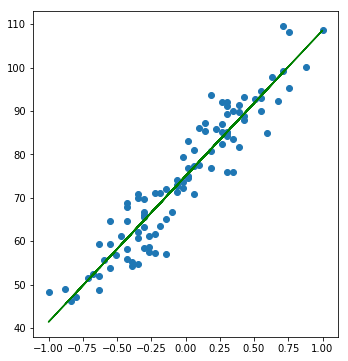

In [15]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [13]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


In [14]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1. -1. -1.] [ 1.  1.  1.]


In [15]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))
nn.fit(x, y, epochs=2000, verbose=200)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

epoch:    0/2000 cost: 25966.20130110
epoch:  200/2000 cost: 6.99986145
epoch:  400/2000 cost: 5.83882690
epoch:  600/2000 cost: 5.74941706
epoch:  800/2000 cost: 5.73927914
epoch: 1000/2000 cost: 5.73799752
epoch: 1200/2000 cost: 5.73783186
epoch: 1400/2000 cost: 5.73781035
epoch: 1600/2000 cost: 5.73780756
epoch: 1800/2000 cost: 5.73780720
epoch: 2000/2000 cost: 5.73780715
[[  8.72095408  14.10518605  26.2673159 ]]
[[ 150.65173151]]


### Regressão Quadrática

In [16]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [17]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/10000 cost: 1890.31765995
epoch: 1000/10000 cost: 177.67118330
epoch: 2000/10000 cost: 60.22414254
epoch: 3000/10000 cost: 37.75076092
epoch: 4000/10000 cost: 31.59818499
epoch: 5000/10000 cost: 29.12069329
epoch: 6000/10000 cost: 27.86196629
epoch: 7000/10000 cost: 27.12797203
epoch: 8000/10000 cost: 26.65565139
epoch: 9000/10000 cost: 26.33242227
epoch: 10000/10000 cost: 26.09330243


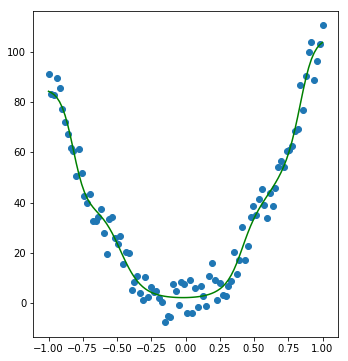

In [18]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-5)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=10000, verbose=1000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

In [19]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [20]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/10000 cost: 102.29549605
epoch: 1000/10000 cost: 45.45458289
epoch: 2000/10000 cost: 20.41944999
epoch: 3000/10000 cost: 10.80525901
epoch: 4000/10000 cost: 7.23786706
epoch: 5000/10000 cost: 5.62858990
epoch: 6000/10000 cost: 4.66855330
epoch: 7000/10000 cost: 4.04169751
epoch: 8000/10000 cost: 3.62379669
epoch: 9000/10000 cost: 3.33922207
epoch: 10000/10000 cost: 3.14140085


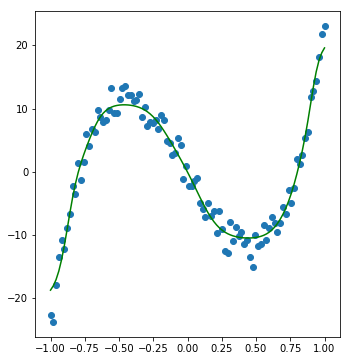

In [21]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-5)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=10000, verbose=1000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

In [22]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [23]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/10000 cost: 9.52400434
epoch: 1000/10000 cost: 0.03762241
epoch: 2000/10000 cost: 0.03282497
epoch: 3000/10000 cost: 0.03116245
epoch: 4000/10000 cost: 0.03035203
epoch: 5000/10000 cost: 0.02980548
epoch: 6000/10000 cost: 0.02937386
epoch: 7000/10000 cost: 0.02900788
epoch: 8000/10000 cost: 0.02868613
epoch: 9000/10000 cost: 0.02839716
epoch: 10000/10000 cost: 0.02813394


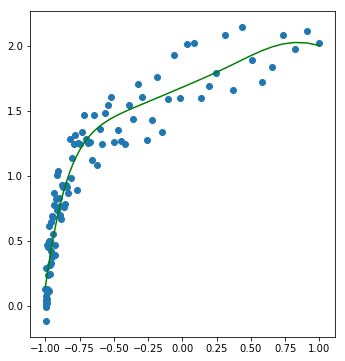

In [24]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-4)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=10000, verbose=1000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

In [25]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [26]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/10000 cost: 2711.82994601
epoch: 1000/10000 cost: 32.21283730
epoch: 2000/10000 cost: 31.57164468
epoch: 3000/10000 cost: 31.16034718
epoch: 4000/10000 cost: 30.87221618
epoch: 5000/10000 cost: 30.71933741
epoch: 6000/10000 cost: 30.57076023
epoch: 7000/10000 cost: 30.42418622
epoch: 8000/10000 cost: 30.27749473
epoch: 9000/10000 cost: 30.13379567
epoch: 10000/10000 cost: 29.99414371


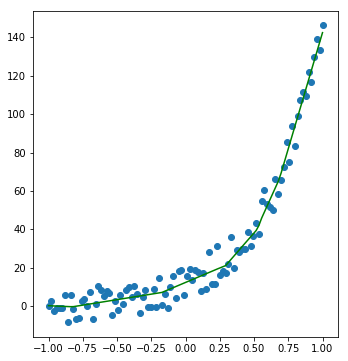

In [27]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-5)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=10000, verbose=1000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

In [28]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/5000 cost: 1.44067861
epoch: 1000/5000 cost: 0.04571882
epoch: 2000/5000 cost: 0.03106262
epoch: 3000/5000 cost: 0.02490639
epoch: 4000/5000 cost: 0.02133582
epoch: 5000/5000 cost: 0.01894160
[[ 7.28117927  7.28117927]] [[-11.00929703]]
[[  1.65468704e-05]
 [  2.34737752e-02]
 [  2.34737752e-02]
 [  9.72160405e-01]]


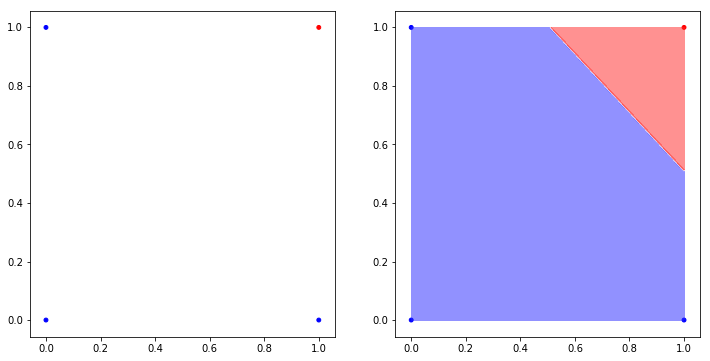

In [29]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

print(nn.layers[0].weights, nn.layers[0].biases)
print(nn.predict(x))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Porta XOR

In [30]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/5000 cost: 0.70125593
epoch: 1000/5000 cost: 0.04445141
epoch: 2000/5000 cost: 0.02837472
epoch: 3000/5000 cost: 0.02230274
epoch: 4000/5000 cost: 0.01891548
epoch: 5000/5000 cost: 0.01669083
[[ 0.01827512]
 [ 0.98429447]
 [ 0.98418857]
 [ 0.01640769]]


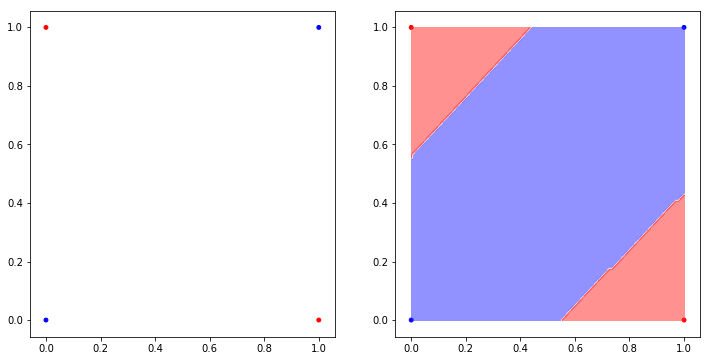

In [31]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)
print(nn.predict(x))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 2 Clusters

In [32]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


epoch:    0/5000 cost: 1.94722828
epoch: 1000/5000 cost: 0.03191437
epoch: 2000/5000 cost: 0.02236894
epoch: 3000/5000 cost: 0.01804771
epoch: 4000/5000 cost: 0.01545363
epoch: 5000/5000 cost: 0.01367880


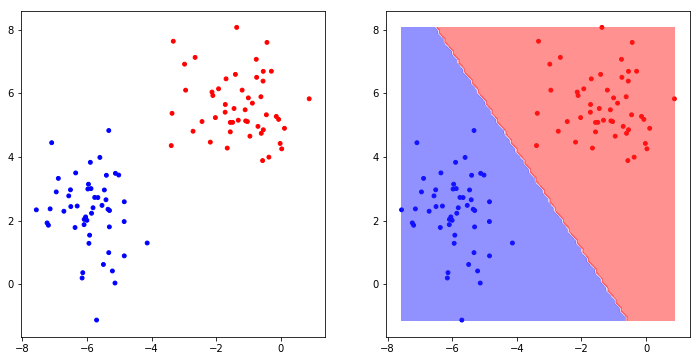

In [33]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 4 Clusters

In [34]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/5000 cost: 0.57143167
epoch: 1000/5000 cost: 0.02645723
epoch: 2000/5000 cost: 0.01709788
epoch: 3000/5000 cost: 0.01332144
epoch: 4000/5000 cost: 0.01119071
epoch: 5000/5000 cost: 0.00979355


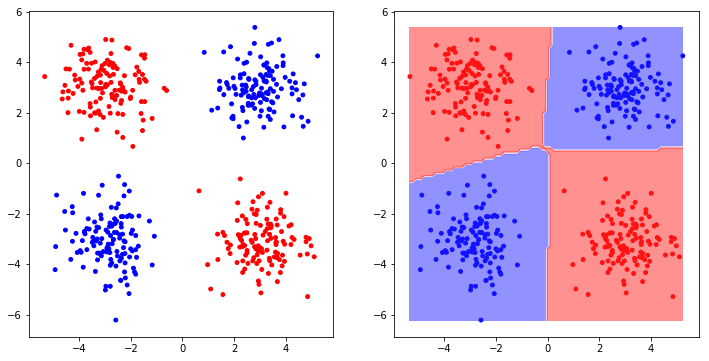

In [38]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

In [39]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/10000 cost: 0.92995384
epoch: 1000/10000 cost: 0.03263080
epoch: 2000/10000 cost: 0.01718561
epoch: 3000/10000 cost: 0.01188491
epoch: 4000/10000 cost: 0.00928191
epoch: 5000/10000 cost: 0.00768983
epoch: 6000/10000 cost: 0.00662220
epoch: 7000/10000 cost: 0.00584690
epoch: 8000/10000 cost: 0.00525817
epoch: 9000/10000 cost: 0.00479494
epoch: 10000/10000 cost: 0.00440952


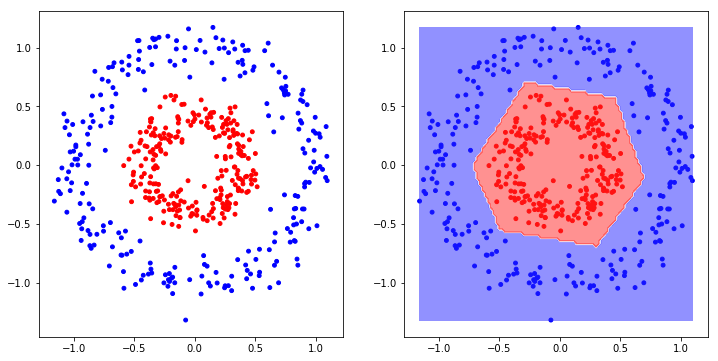

In [40]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

In [41]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/20000 cost: 0.62886738
epoch: 2000/20000 cost: 0.26880796
epoch: 4000/20000 cost: 0.20137704
epoch: 6000/20000 cost: 0.15458213
epoch: 8000/20000 cost: 0.13528795
epoch: 10000/20000 cost: 0.12559431
epoch: 12000/20000 cost: 0.11983212
epoch: 14000/20000 cost: 0.11600803
epoch: 16000/20000 cost: 0.11328878
epoch: 18000/20000 cost: 0.11128050
epoch: 20000/20000 cost: 0.10977654


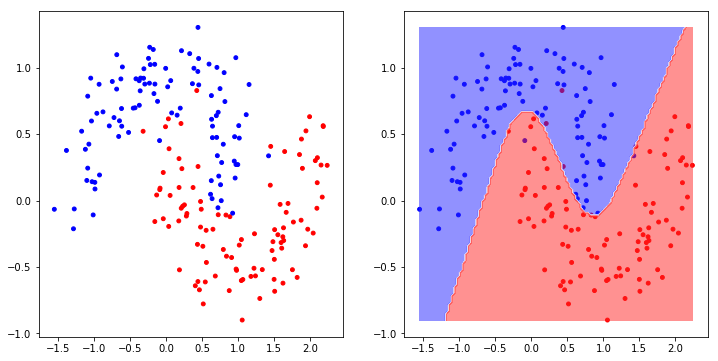

In [44]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=tanh))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=20000, verbose=2000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Espiral

In [45]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/20000 cost: 0.96051006
epoch: 2000/20000 cost: 0.50857255
epoch: 4000/20000 cost: 0.28716220
epoch: 6000/20000 cost: 0.16765474
epoch: 8000/20000 cost: 0.12615439
epoch: 10000/20000 cost: 0.09948553
epoch: 12000/20000 cost: 0.07402950
epoch: 14000/20000 cost: 0.06121069
epoch: 16000/20000 cost: 0.05422583
epoch: 18000/20000 cost: 0.04931822
epoch: 20000/20000 cost: 0.04555402


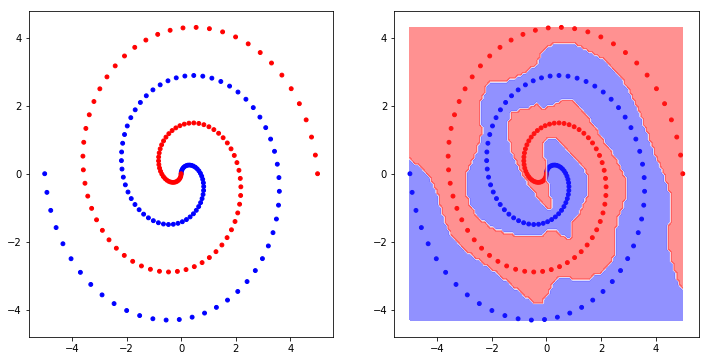

In [47]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=8, activation=tanh))
nn.layers.append(Layer(input_dim=8, output_dim=8, activation=tanh))
nn.layers.append(Layer(input_dim=8, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=20000, verbose=2000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters Multiclasse

In [48]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(300, 2) (300, 1)


In [49]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]]


epoch:    0/10000 cost: 3.75114106
epoch: 1000/10000 cost: 0.30385908
epoch: 2000/10000 cost: 0.17580935
epoch: 3000/10000 cost: 0.09576885
epoch: 4000/10000 cost: 0.06317080
epoch: 5000/10000 cost: 0.04435019
epoch: 6000/10000 cost: 0.03387774
epoch: 7000/10000 cost: 0.02692933
epoch: 8000/10000 cost: 0.02209708
epoch: 9000/10000 cost: 0.01862550
epoch: 10000/10000 cost: 0.01597194


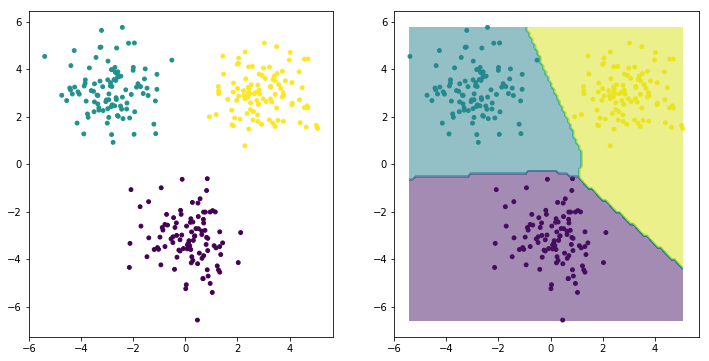

In [50]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=relu))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### 4 Clusters Multiclasse

In [51]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(400, 2) (400, 1)


In [52]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]]


epoch:    0/10000 cost: 2.08156157
epoch: 1000/10000 cost: 0.22794438
epoch: 2000/10000 cost: 0.16512581
epoch: 3000/10000 cost: 0.13432947
epoch: 4000/10000 cost: 0.11811134
epoch: 5000/10000 cost: 0.10891030
epoch: 6000/10000 cost: 0.10307599
epoch: 7000/10000 cost: 0.09901449
epoch: 8000/10000 cost: 0.09607563
epoch: 9000/10000 cost: 0.09385400
epoch: 10000/10000 cost: 0.09209379


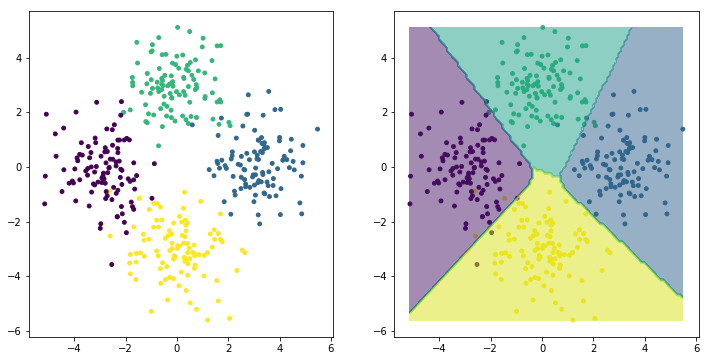

In [53]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

In [54]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


In [55]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]]


epoch:    0/10000 cost: 7.68566106
epoch: 1000/10000 cost: 0.17056886
epoch: 2000/10000 cost: 0.09255144
epoch: 3000/10000 cost: 0.06842642
epoch: 4000/10000 cost: 0.05648239
epoch: 5000/10000 cost: 0.04918154
epoch: 6000/10000 cost: 0.04409905
epoch: 7000/10000 cost: 0.04036040
epoch: 8000/10000 cost: 0.03756459
epoch: 9000/10000 cost: 0.03539469
epoch: 10000/10000 cost: 0.03362260


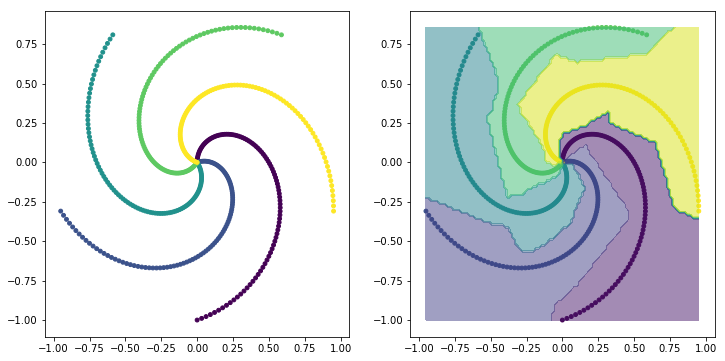

In [56]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

In [57]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


In [58]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]]


epoch:    0/10000 cost: 1.68561440
epoch: 1000/10000 cost: 0.33513232
epoch: 2000/10000 cost: 0.26932595
epoch: 3000/10000 cost: 0.23872287
epoch: 4000/10000 cost: 0.22083341
epoch: 5000/10000 cost: 0.20808667
epoch: 6000/10000 cost: 0.19786159
epoch: 7000/10000 cost: 0.18915066
epoch: 8000/10000 cost: 0.18185635
epoch: 9000/10000 cost: 0.17573597
epoch: 10000/10000 cost: 0.17051782


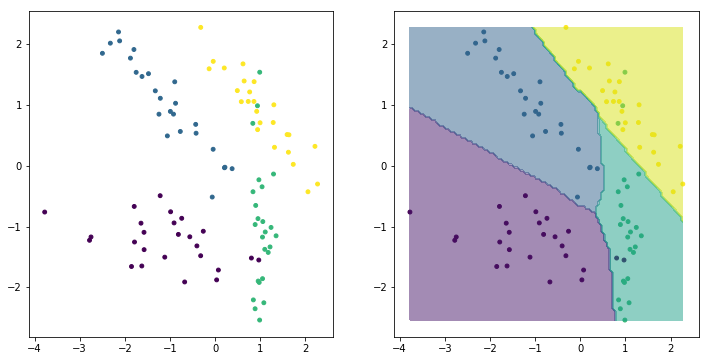

In [60]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Iris Dataset

In [61]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


In [62]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]


epoch:    0/10000 cost: 1.43049068
epoch: 1000/10000 cost: 0.41894957
epoch: 2000/10000 cost: 0.23681328
epoch: 3000/10000 cost: 0.16866593
epoch: 4000/10000 cost: 0.13750207
epoch: 5000/10000 cost: 0.12024933
epoch: 6000/10000 cost: 0.10930865
epoch: 7000/10000 cost: 0.10171721
epoch: 8000/10000 cost: 0.09612397
epoch: 9000/10000 cost: 0.09183297
epoch: 10000/10000 cost: 0.08844288


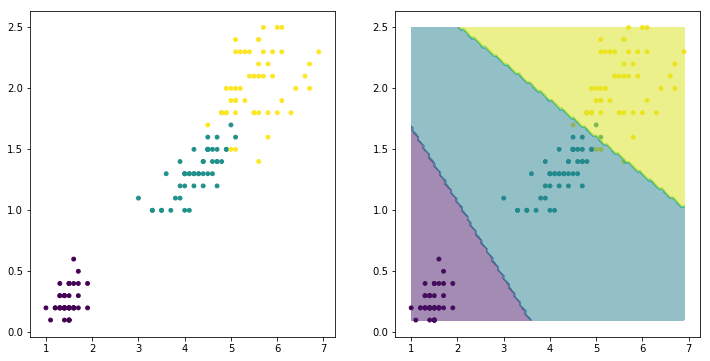

In [63]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=relu))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

# Referências

- [Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

- [Implementing Neural Network L1 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/27/implementing-neural-network-l1-regularization/)

- [Linear Classification](http://cs231n.github.io/linear-classify/)

__TODO__:
- evitar overflow das funções de ativação
- mini-batch SGD
- dropout
- early_stopping

```py
def stablesoftmax(x):
    """Compute the softmax of vector x in a numerically stable way."""
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)
```

__NOTAS__:

__Inicialização dos pesos__:
- mostrar a documentação das funções np.random.rand e np.random.randn para mostrar como gerar distribuições na faixa [-limit, limit] e com média zero e certo desvio-padrão.
- mostrar que os métodos de inicialização de pesos ones e random_uniform podem não ser adequados para alguns problemas, como o do espiral binário.

__Regularização__:
- mostrar que a regularização dos pesos nem sempre ajuda. Em alguns casos, como o espiral multiclasse, temos que definir a reg_strength muito pequena. Isto é, estamos dizendo que o valores dos pesos não podem influenciar no custo. Em outras palavras, isso é a mesma coisa que "desligar" a regularização.